In [1]:
import math
import numpy as np
import bisect
import matplotlib.pyplot as plt

In [2]:
"""
Cubic spline planner
Author: Atsushi Sakai(@Atsushi_twi)
"""
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B



In [3]:

class Spline2D:
    """
    2D Cubic Spline class
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

In [4]:
def main():
    print("Spline 2D test")
    import matplotlib.pyplot as plt

    x = [5*np.cos(i) for i in range ( 359 )]
    y = [5*np.sin(i) for i in range ( 359 )]
    x.append(50)
    y.append(60)
    ds = 0.1  # [m] distance of each intepolated points

    sp = Spline2D(x, y)
    s = np.arange(0, sp.s[-1], ds)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    flg, ax = plt.subplots(1)
    plt.plot(x, y, "xb", label="input")
    plt.plot(rx, ry, "-r", label="spline")
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.legend()

    flg, ax = plt.subplots(1)
    plt.plot(s, [math.degrees(iyaw) for iyaw in ryaw], "-r", label="yaw")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    flg, ax = plt.subplots(1)
    plt.plot(s, rk, "-r", label="curvature")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()



Spline 2D test
[[  1.           0.           0.         ...   0.           0.
    0.        ]
 [  4.79425539  19.17702154   4.79425539 ...   0.           0.
    0.        ]
 [  0.           4.79425539  19.17702154 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  19.17702154   4.79425539
    0.        ]
 [  0.           0.           0.         ...   4.79425539 160.77919467
   75.59534195]
 [  0.           0.           0.         ...   0.           0.
    1.        ]]
[[  1.           0.           0.         ...   0.           0.
    0.        ]
 [  4.79425539  19.17702154   4.79425539 ...   0.           0.
    0.        ]
 [  0.           4.79425539  19.17702154 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  19.17702154   4.79425539
    0.        ]
 [  0.           0.           0.         ...   4.79425539 160.77919467
   75.59534195]
 [  0.           0.           0.         ...   0.           0.
    1.    

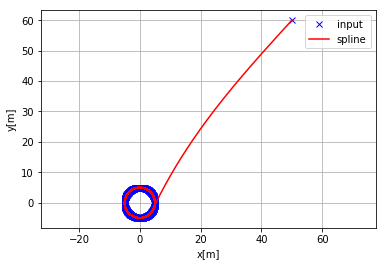

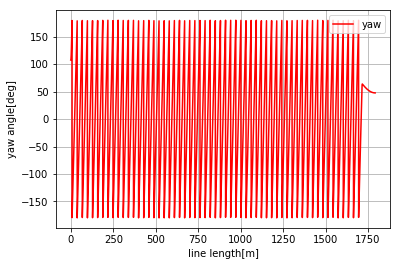

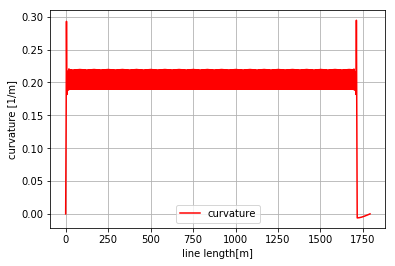

In [5]:
if __name__ == '__main__':
    main()

In [20]:
x = [5*np.cos(i) for i in range ( 360 )]
y = [5*np.sin(i) for i in range ( 360 )]


[5.0,
 2.701511529340699,
 -2.080734182735712,
 -4.949962483002227,
 -3.2682181043180596,
 1.4183109273161312,
 4.80085143325183,
 3.769511271716523,
 -0.7275001690430677,
 -4.555651309423385,
 -4.195357645382262,
 0.022128489940253928,
 4.219269793662461,
 4.537233907250981,
 0.683686091039168,
 -3.7984395642941067,
 -4.788297401616923,
 -1.3758166902579847,
 3.301583541220401,
 4.943523090933346,
 2.0404103090669596,
 -2.7386463011213418,
 -4.999804131973185,
 -2.6641651016669874,
 2.120895036684985,
 4.956014059317368,
 3.2345966116432017,
 -1.4606940436691809,
 -4.813029331567833,
 -3.7402876484450016,
 0.7712572494379202,
 4.573711789022656,
 4.171116802532551,
 -0.0663837361152974,
 -4.242851373923026,
 -4.518461025457533,
 -0.6398184481370234,
 3.827070259726717,
 4.775368220236475,
 1.3332146617996863,
 -3.3346903082613095,
 -4.936696387619132,
 -1.9999265749417563,
 2.7755665076031284,
 4.999216543238456,
 2.626609944088649,
 -2.1608897244238916,
 -4.9616773457546435,
 -3.2007

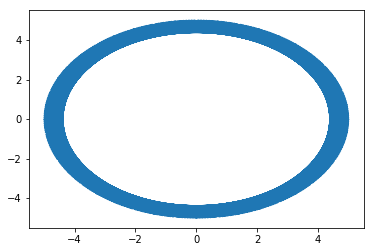

In [26]:
plt.plot(x,y)

In [16]:
def calc_A(h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((nx, nx))
        A[0, 0] = 1.0
        for i in range(nx - 1):
            if i != (nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[nx - 1, nx - 2] = 0.0
        A[nx - 1, nx - 1] = 1.0
        #print(A)
        return A

def calc_B(h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(nx)
        for i in range(nx - 2):
            B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / \
                h[i + 1] - 3.0 * (a[i + 1] - a[i]) / h[i]
        return B


b, c, d, w = [], [], [], []
x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
nx = len(x)  # dimension of x
h = np.diff(x)
# calc coefficient c
a = [iy for iy in y]
# calc coefficient c
A = calc_A(h)
B = calc_B(h)
c = np.linalg.solve(A, B)
#  print(self.c1)
# calc spline coefficient b and d
for i in range(nx - 1):
    d.append((c[i + 1] - c[i]) / (3.0 * h[i]))
    tb = (a[i + 1] - a[i]) / h[i] - h[i] * \
                (c[i + 1] + 2.0 * c[i]) / 3.0
    b.append(tb)

[[  1.    0.    0.    0.    0.    0.    0. ]
 [  2.5  10.    2.5   0.    0.    0.    0. ]
 [  0.    2.5  10.    2.5   0.    0.    0. ]
 [  0.    0.    2.5  10.    2.5   0.    0. ]
 [  0.    0.    0.    2.5  -4.   -4.5   0. ]
 [  0.    0.    0.    0.   -4.5 -17.   -4. ]
 [  0.    0.    0.    0.    0.    0.    1. ]]


In [25]:
B

array([  0.        ,  21.24      , -11.4       ,  -9.6       ,
         4.46666667,   8.58333333,   0.        ])

7